# 1. Facebook Prophet Testing

## I - Setup

In [1]:
# Import of librairies

import mysql.connector as mariadb
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [3]:
# Taking data from  station 9034 - Madeleine

request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT DISTINCT * FROM velib_realtime
WHERE station_id = 9034
AND date_of_update > DATE("2020-05-05")
ORDER BY date_of_update ASC
"""

df_full = request(query)

In [4]:
df_full.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
0,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
1,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
3,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
4,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


In [5]:
df = df_full[['date_of_update','nb_free_docks']]

# Adopting FB Prophet terminology for easier use
df.columns = ['ds','y']
df.head()

,ds,y
0,2020-05-05 00:01:00,20
1,2020-05-05 00:02:00,20
2,2020-05-05 00:03:00,20
3,2020-05-05 00:04:00,20
4,2020-05-05 00:05:00,20


In [6]:
import seaborn as sns

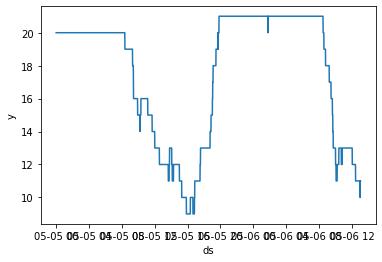

In [7]:
_ = sns.lineplot(x="ds", y="y", data=df)

In [8]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=180, freq='min')
future.tail

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<bound method NDFrame.tail of                       ds
0    2020-05-05 00:01:00
1    2020-05-05 00:02:00
2    2020-05-05 00:03:00
3    2020-05-05 00:04:00
4    2020-05-05 00:05:00
...                  ...
2395 2020-05-06 15:59:00
2396 2020-05-06 16:00:00
2397 2020-05-06 16:01:00
2398 2020-05-06 16:02:00
2399 2020-05-06 16:03:00

[2400 rows x 1 columns]>

In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2395,2020-05-06 15:59:00,5.707346,3.528238,7.796294
2396,2020-05-06 16:00:00,5.680637,3.579868,7.810637
2397,2020-05-06 16:01:00,5.653928,3.506693,7.702583
2398,2020-05-06 16:02:00,5.627219,3.596158,7.791802
2399,2020-05-06 16:03:00,5.600509,3.492394,7.697392


In [10]:
forecast_full = forecast
forecast_full['y'] = df['y']
# Replacing y Nan values with last values known
# forecast_full['y'].iloc[df.shape[0]:] = forecast_full['y'].iloc[df.shape[0]-1]
forecast_full['yhat_round'] = forecast_full['yhat'].apply(lambda x: round(x))

In [11]:
forecast_full.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,yhat_round
0,2020-05-05 00:01:00,20.017054,18.892783,21.113750,20.017054,20.017054,0.0,0.0,0.0,0.0,0.0,0.0,20.017054,20.0,20
1,2020-05-05 00:02:00,20.017068,18.852491,21.112064,20.017068,20.017068,0.0,0.0,0.0,0.0,0.0,0.0,20.017068,20.0,20
2,2020-05-05 00:03:00,20.017081,18.924457,21.028664,20.017081,20.017081,0.0,0.0,0.0,0.0,0.0,0.0,20.017081,20.0,20
3,2020-05-05 00:04:00,20.017094,18.910382,21.106344,20.017094,20.017094,0.0,0.0,0.0,0.0,0.0,0.0,20.017094,20.0,20
4,2020-05-05 00:05:00,20.017108,18.900916,21.114717,20.017108,20.017108,0.0,0.0,0.0,0.0,0.0,0.0,20.017108,20.0,20


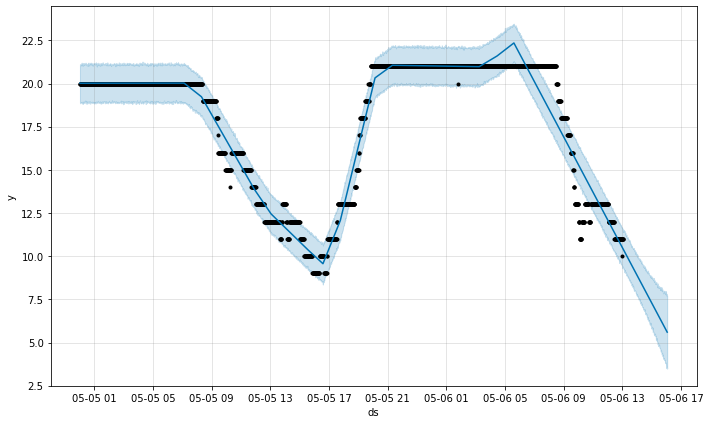

In [12]:
fig1 = m.plot(forecast)

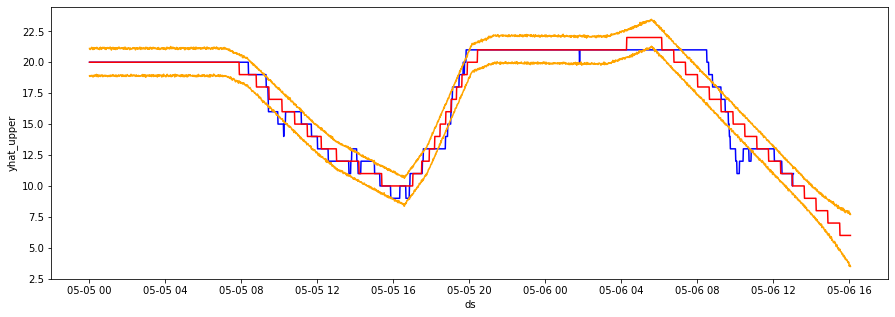

In [13]:
fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full, color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full, color="red")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full, color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full, color="orange")
plt.show()
